In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from numpy.linalg import inv, det
from math import sqrt, pi
from functools import partial
# Map voxels to 2D feature space (work in 3D) Each voxel in 3D -> apply model

In [2]:
data_path = "./P2_data/1"
T1 = os.path.join(data_path, 'T1.nii')
T2_flair = os.path.join(data_path, 'T2_FLAIR.nii')
Labels = os.path.join(data_path, 'LabelsForTesting.nii')

T1_img = nib.load(T1)
T2_flair_img = nib.load(T2_flair)
Labels_img = nib.load(Labels)

print(T1_img.shape,
T2_flair_img.shape,
Labels_img.shape)


(240, 240, 48) (240, 240, 48) (240, 240, 48)


In [3]:
hdr = T1_img.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240  48   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.958333   0.95833254 2.9999986  0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : -0.14366025
quatern_d       : 0.98962706
qoffset_x       : 110.892
qoffset_y       : 115.17

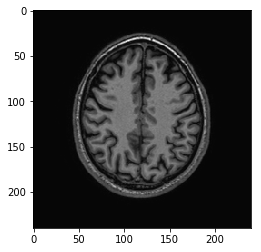

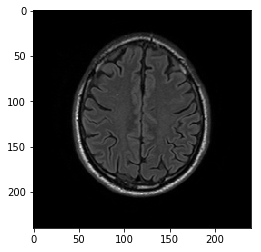

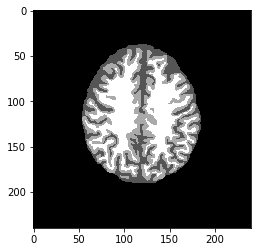

In [41]:
def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, :, 30]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()
    
    
def seg_data_to_nii(original_im, y_pred, features_nonzero_row_indicies):
    """
        Inputs: original_im (nibabel): original image nii file
                y_pred (np array): labels for all non-zero points
                features_nonzero_row_indicies (np array): indicies of non-zero points,
                                                          same length as y_pred
        Returns: segment_nii (nibabel): segmented labels nii file        
        """
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred) + 1
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)
    return segment_nii

def soriginal_im, y_pred, features_nonzero, features_nonzero_row_indicies):
    """
        Inputs: original_im (nibabel): original image nii file
                y_pred (np array): labels for all non-zero points
                features_nonzero (np array): feature vector of only non-zero intensities
                features_nonzero_row_indicies (np array): indicies of non-zero points,
                                                          same length as y_pred
        Returns: segment_nii (nibabel): segmented labels nii file        
        """
    
    #Show labels correct values
    #The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
    class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0],0]
    class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0],0]
    class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0],0]
    mean0 = np.mean(class0, axis = 0)
    mean1 = np.mean(class1, axis = 0)
    mean2 = np.mean(class2, axis = 0)

    WM_label = np.argmax([mean0,mean1,mean2])
    CSF_label = np.argmin([mean0,mean1,mean2])
    if (WM_label + CSF_label) == 1:
        GM_label = 2
    elif (WM_index + CSF_label) == 3:
        GM_label = 0
    elif (WM_index + CSF_label) == 2:
        GM_label = 3
    print(mean0,mean1,mean2)


    #New y_pred
    y_pred_corrected_labels = np.zeros_like(y_pred)
    #Assign CSF to 1
    y_pred_corrected_labels[y_pred == CSF_label] = 1
    #Assign GM to 2
    y_pred_corrected_labels[y_pred == GM_label] = 2
    #Assign WM to 1
    y_pred_corrected_labels[y_pred == WM_label] = 3

    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred_corrected_labels)
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)
    return segment_nii

def dice_similarity(segmented_img, groundtruth_img):
    """
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
        """
 
    return DICE_index


show_slice(T1_img, np.s_[:, :, 30])
show_slice(T2_flair_img, np.s_[:, :, 30])
show_slice(Labels_img, np.s_[:, :, 30])

In [8]:
# Create mask using groundtruth image
def apply_mask(target_img, gt_img):
    """
    Inputs: gt_img: groundtuth mask
            target_img: raw data, apply mask to it
    Returns: masked_img: target image with mask applied (background removed)
    """
    
    gt_data = gt_img.get_data().copy()
    target_data = target_img.get_data().copy()
    
    # Create mask: Select pixels higher than 0 in gt and set to 1
    gt_data[gt_data > 0] = 1
    
    # Apply mask
    target_data = np.multiply(target_data, gt_data)
    
    masked_img = nib.Nifti1Image(target_data, target_img.affine, target_img.header)
    
    return masked_img

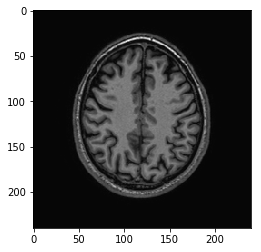

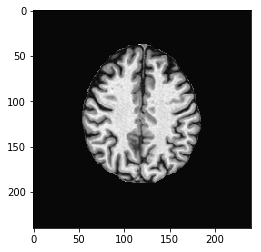

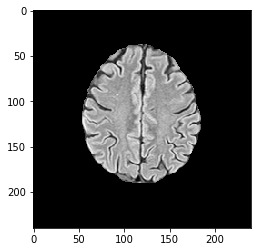

In [9]:
show_slice(T1_img, np.s_[:, :, 30])
T1_masked = apply_mask(T1_img, Labels_img)
T2_masked = apply_mask(T2_flair_img, Labels_img)
show_slice(T1_masked, np.s_[:, :, 30])
show_slice(T2_masked, np.s_[:, :, 30])

## K-means initialization

In [10]:
T1_flat = T1_masked.get_data().copy().flatten()
T2_flat = T2_masked.get_data().copy().flatten()

features = np.vstack((T1_flat, T2_flat))

features = np.transpose(features)

features_nonzero_row_indicies = [i for i, x in enumerate(features) if x.any()]
features_nonzero = features[features_nonzero_row_indicies]

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(features_nonzero)
centroids = kmeans.cluster_centers_
y_pred = kmeans.predict(features_nonzero)

In [9]:
np.unique(kmeans)

array([KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)], dtype=object)

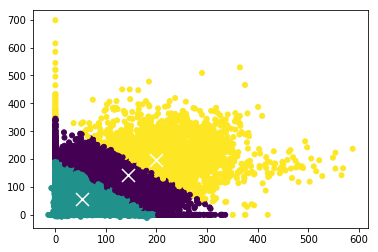

In [10]:
# plt.figure()
# plt.scatter(features_nonzero[:, 0], features_nonzero[:, 1], c=y_pred, s=25)
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
# plt.show()

# EM Algorithm

In [12]:
def gaussian_mixture(features, mean, cov):
    return np.exp(-0.5*(features - mean) @ inv(cov) @ np.transpose(features - mean)) / (2 * pi * sqrt(det(cov)))

def membership_weight(p0, p1, p2, a0, a1, a2):
    denominator = (p0 * a0) + (p1 * a1) + (p2 * a2)
    w0 = (p0 * a0) / denominator
    w1 = (p1 * a1) / denominator
    w2 = (p2 * a2) / denominator
    return np.stack((w0, w1, w2), axis=1)

0.2667414332401672 0.365233981407656 0.36802458535217686


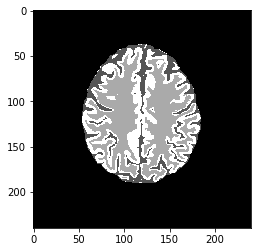

In [13]:
# Initialization
class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0],:]
class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0],:]
class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0],:]

# Compute mean and variance of each class
mean0 = np.mean(class0, axis = 0)
mean1 = np.mean(class1, axis = 0)
mean2 = np.mean(class2, axis = 0)
cov0 = np.cov(class0, rowvar = False)
cov1 = np.cov(class1, rowvar = False)
cov2 = np.cov(class2, rowvar = False)

# Class distribution
a0 = class0.shape[0] / features_nonzero.shape[0]
a1 = class1.shape[0] / features_nonzero.shape[0]
a2 = class2.shape[0] / features_nonzero.shape[0]


#while a0

for i in range (0,1):
    # Expectation step: Recompute labels for all the dataset given the current cluster parameters.

    # Compute Gaussian mixture model for each point
    p0 = np.apply_along_axis(partial(gaussian_mixture, mean = mean0, cov = cov0), 1, features_nonzero)
    p1 = np.apply_along_axis(partial(gaussian_mixture, mean = mean1, cov = cov1), 1, features_nonzero)
    p2 = np.apply_along_axis(partial(gaussian_mixture, mean = mean2, cov = cov2), 1, features_nonzero)

    # # Compute membership weight for each point
    weights = membership_weight(p0, p1, p2, a0, a1, a2)

    #################################### 

    # Maximization step: Use that classification to reestimate the parameters
    y_pred = np.argmax(weights, axis=1)

    # Class distribution
    _, counts = np.unique(y_pred, return_counts=True)
    a0 = counts[0] / features_nonzero.shape[0]
    a1 = counts[1] / features_nonzero.shape[0]
    a2 = counts[2] / features_nonzero.shape[0]

    # Calculate mean and covariance for new class
    mean0 = (1/counts[0]) * (weights[:, 0] @ features_nonzero)
    mean1 = (1/counts[1]) * weights[:, 1] @ features_nonzero
    mean2 = (1/counts[2]) * weights[:, 2] @ features_nonzero
    cov0 = (1/counts[0]) * (weights[:, 0] * np.transpose(features_nonzero - mean0)) @ (features_nonzero - mean0)
    cov1 = (1/counts[1]) * (weights[:, 1] * np.transpose(features_nonzero - mean1)) @ (features_nonzero - mean1)
    cov2 = (1/counts[2]) * (weights[:, 2] * np.transpose(features_nonzero - mean2)) @ (features_nonzero - mean2)
    print(a0, a1, a2)
    segment_img = seg_data_to_nii(T1_img, y_pred, features_nonzero_row_indicies)
    show_slice(segment_img, np.s_[:, :, 30])
    

In [ ]:
plt.figure()
plt.hist(y_pred, bins='auto')  
plt.show()

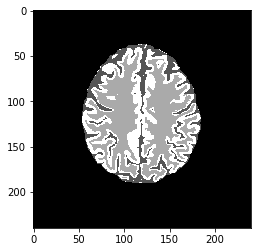

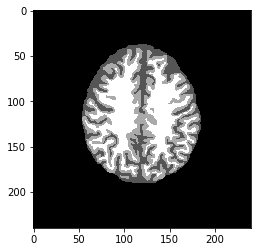

In [14]:
show_slice(segment_img, np.s_[:, :, 30])
show_slice(Labels_img, np.s_[:, :, 30])

In [38]:
#Show labels correct values
#The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0],0]
class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0],0]
class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0],0]
mean0 = np.mean(class0, axis = 0)
mean1 = np.mean(class1, axis = 0)
mean2 = np.mean(class2, axis = 0)

WM_label = np.argmax([mean0,mean1,mean2])
CSF_label = np.argmin([mean0,mean1,mean2])
if (WM_label + CSF_label) == 1:
    GM_label = 2
elif (WM_index + CSF_label) == 3:
    GM_label = 0
elif (WM_index + CSF_label) == 2:
    GM_label = 3
print(mean0,mean1,mean2)


#New y_pred
y_pred_corrected_labels = np.zeros_like(y_pred)
#Assign CSF to 1
y_pred_corrected_labels[y_pred == CSF_label] = 1
#Assign GM to 2
y_pred_corrected_labels[y_pred == GM_label] = 2
#Assign WM to 1
y_pred_corrected_labels[y_pred == WM_label] = 3

47.21136348705821 209.35329642979232 129.41366544653752


47.21136348705821 209.35329642979232 129.41366544653752


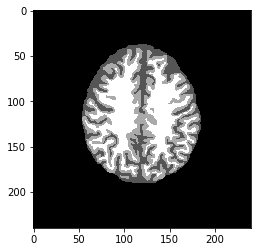

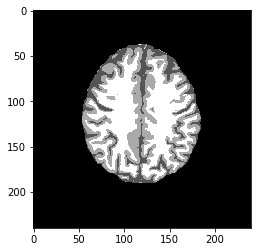

In [42]:
#segment_img = seg_data_to_nii(T1_img, y_pred_corrected_labels, features_nonzero_row_indicies)
segment_img = seg_data_change_labels_to_nii(T1_img, y_pred, features_nonzero, features_nonzero_row_indicies)
show_slice(Labels_img, np.s_[:, :, 30])
show_slice(segment_img, np.s_[:, :, 30])

In [30]:
seg_data_change_labels_to_nii(original_im, y_pred, features_nonzero, features_nonzero_row_indicies)

2

In [31]:
print(mean0,mean1,mean2)

2.7109888989510678 1.7645864952534 nan
